<a href="https://colab.research.google.com/github/limited-fion/deep-learning-cw/blob/master/04_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.ndimage as nd
import tensorflow as tf
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from matplotlib import font_manager as fm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model
from keras import regularizers
from keras import initializers
from keras import metrics
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU 
from keras import layers
from keras import models
from keras.optimizers import Adam
from keras import backend as K

from google.colab import drive
import os
drive.mount('/content/drive')

!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# Use your new font on all your plots.
plt.rc('font', family='serif')

def plot_history(history, fileName, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  # Be careful because the axis ranges are automatically adapted
  # which may not desirable to compare different runs.
  # Also, in some cases you may want to combine several curves in one
  # figure for easier comparison, which this function does not do.

  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Training', 'Validation'], fontsize=14)
      axes[0].tick_params(axis='x', which='major', labelsize=12)
      axes[0].tick_params(axis='y', which='major', labelsize=12)
    except:
      pass
    axes[0].set_title('Validation Accuracy', fontsize = 18)
    axes[0].set_ylabel('Accuracy', fontsize = 14)
    axes[0].set_xlabel('Epoch', fontsize = 14)
    fig.subplots_adjust(hspace=0.35)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Training', 'Validation'], fontsize=14)
      axes[1].tick_params(axis='x', which='major', labelsize=12)
      axes[1].tick_params(axis='y', which='major', labelsize=12)
    except:
      pass
    axes[1].set_title('Model Loss', fontsize = 18)
    axes[1].set_ylabel('Loss', fontsize = 14)
    axes[1].set_xlabel('Epoch', fontsize = 14)
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Training', 'Validation'], fontsize=14)
    except:
      pass
    plt.title('Model Loss', fontsize = 18)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.ylabel('Loss', fontsize = 14)
    plt.xlabel('Epoch', fontsize = 14)

  directory = '/content/drive/MyDrive/dl-cw-04/diagrams/'
  
  if not os.path.exists(directory):
    os.makedirs(directory)

  plt.savefig(os.path.join(directory, fileName))

# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])
        
    return result

def get_data(id_dict):

    print('starting loading data')
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]
        
        train_labels_ = np.array([[0]*200]*450)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()
        
        val_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450, 500)]
        
        val_labels_ = np.array([[0]*200]*50)
        val_labels_[:, value] = 1
        val_labels += val_labels_.tolist()

    for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread('IMagenet/tiny-imagenet-200/val/images/{}'.format(img_name)))

        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))

    return np.array(train_data), np.array(train_labels), np.array(val_data), np.array(val_labels), np.array(test_data), np.array(test_labels)
  
def shuffle_data(train_data, train_labels, val_data, val_labels):
    # This function shuffles separately the train set and the 
    # validation set
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)
    
    size = len(val_data)
    val_idx = np.arange(size)
    np.random.shuffle(val_idx)

    return train_data[train_idx], train_labels[train_idx], val_data[val_idx], val_labels[val_idx]

train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

# Let's visualize some examples
N=3
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col    
    tmp = cv2.cvtColor(train_data[idx],cv2.COLOR_BGR2RGB)
    axes[row,col].imshow(tmp, cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data, axis=(0, 1, 2, 3))
train_data = (train_data-mean)/(std+1e-7)
val_data = (val_data-mean)/(std+1e-7)
test_data = (test_data-mean)/(std+1e-7)

ValueError: ignored

# **VGG16 trained from scratch**

# **Transfer learning**

In [20]:
import keras
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.applications.vgg16 import VGG16
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.layers import Lambda, Input, Dense, Flatten
from keras.models import Model, Sequential
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Original training data shape: {}'.format(train_data.shape))
print('Original validation data shape: {}'.format(val_data.shape))
print('Training label shape: {}'.format(train_labels.shape))

Original training data shape: (90000, 64, 64, 3)
Original validation data shape: (10000, 64, 64, 3)
Training label shape: (90000, 200)


In [21]:
model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
model.summary()

# Modify dense layers according to the resolution of input image
# Preprocessing to resize image
# ie 32x32
newInput = Input(batch_shape=(None, 64, 64, 3))
resizedImg = Lambda(lambda image: tf.compat.v1.image.resize_images(image, (224, 224)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

# Load VGG16
transferlearning_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
for layer in transferlearning_model.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = transferlearning_model.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
transferlearning_model = Model(transferlearning_model.input, output)

transferlearning_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
transferlearning_model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_tl = transferlearning_model.fit(train_data, train_labels, epochs=3, batch_size=32, validation_data=(val_data, val_labels))
print(" ")
score = transferlearning_model.evaluate(test_data, test_labels)
print(" ")
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
2813/2813 [==============================] - 63s 22ms/step - loss: 2.7061 - categorical_accuracy: 0.3670 - val_loss: 2.3121 - val_categorical_accuracy: 0.4327
Epoch 2/3
2813/2813 [==============================] - 62s 22ms/step - loss: 1.9014 - categorical_accuracy: 0.5205 - val_loss: 2.1746 - val_categorical_accuracy: 0.4692
Epoch 3/3
2813/2813 [==============================] - 62s 22ms/step - loss: 1.4205 - categorical_accuracy: 0.6270 - val_loss: 2.2177 - val_categorical_accuracy: 0.4665
 
313/313 [==============================] - 5s 16ms/step - loss: 2.2653 - categorical_accuracy: 0.4606
 
Test loss: 2.265270233154297
Test accuracy: 0.46059998869895935


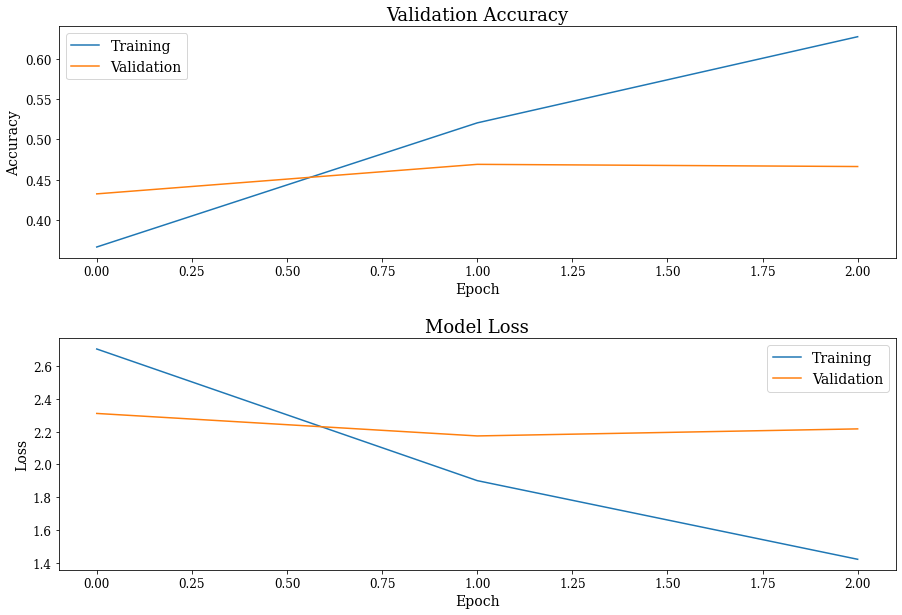

In [28]:
plot_history(history_tl, 'tl.png', metric='categorical_accuracy')

## Fine-tuning

In [8]:
# Load data and preprocessing
train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data, axis=(0, 1, 2, 3))
train_data = (train_data-mean)/(std+1e-7)
val_data = (val_data-mean)/(std+1e-7)
test_data = (test_data-mean)/(std+1e-7)

model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
model.summary()

# Modify dense layers according to the resolution of input image
# Preprocessing to resize image
# ie 32x32
newInput = Input(batch_shape=(None, 64, 64, 3))
resizedImg = Lambda(lambda image: tf.compat.v1.image.resize_images(image, (224, 224)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

# Load VGG16
transferlearning_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
for layer in transferlearning_model.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = transferlearning_model.output
output = Flatten()(output)
output = Dense(units=2048, activation='relu')(output)
output = Dense(units=1024, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
transferlearning_model = Model(transferlearning_model.input, output)

transferlearning_model.summary()

transferlearning_model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
transferlearning_model.fit(train_data, train_labels, epochs=5, batch_size=32)
print(" ")
score = transferlearning_model.evaluate(test_data, test_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

starting loading data
finished loading data, in 11.669900178909302 seconds
Epoch 1/5
 444/2813 [===>..........................] - ETA: 48s - loss: 9.5712 - categorical_accuracy: 0.5897

KeyboardInterrupt: ignored